<a href="https://colab.research.google.com/github/20134571/20134571.github.io/blob/main/Airline_Satisfaction_Heidi_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0                0   70172    Male     Loyal Customer   13  Personal Travel   
1                1    5047    Male  disloyal Customer   25  Business travel   
2                2  110028  Female     Loyal Customer   26  Business travel   
3                3   24026  Female     Loyal Customer   25  Business travel   
4                4  119299    Male     Loyal Customer   61  Business travel   
...            ...     ...     ...                ...  ...              ...   
129875       25971   78463    Male  disloyal Customer   34  Business travel   
129876       25972   71167    Male     Loyal Customer   23  Business travel   
129877       25973   37675  Female     Loyal Customer   17  Personal Travel   
129878       25974   90086    Male     Loyal Customer   14  Business travel   
129879       25975   34799  Female     Loyal Customer   42  Personal Travel   

           Class  Flight Distance  Inflight wifi se

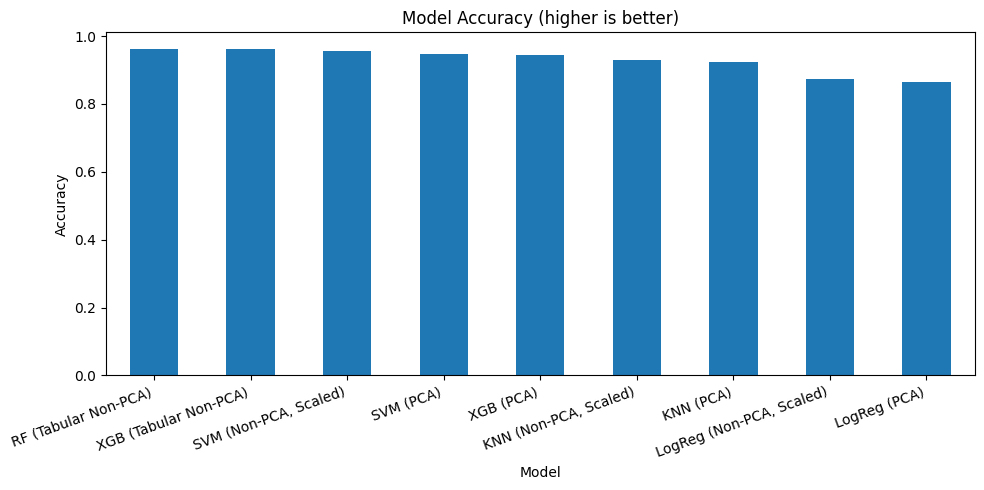

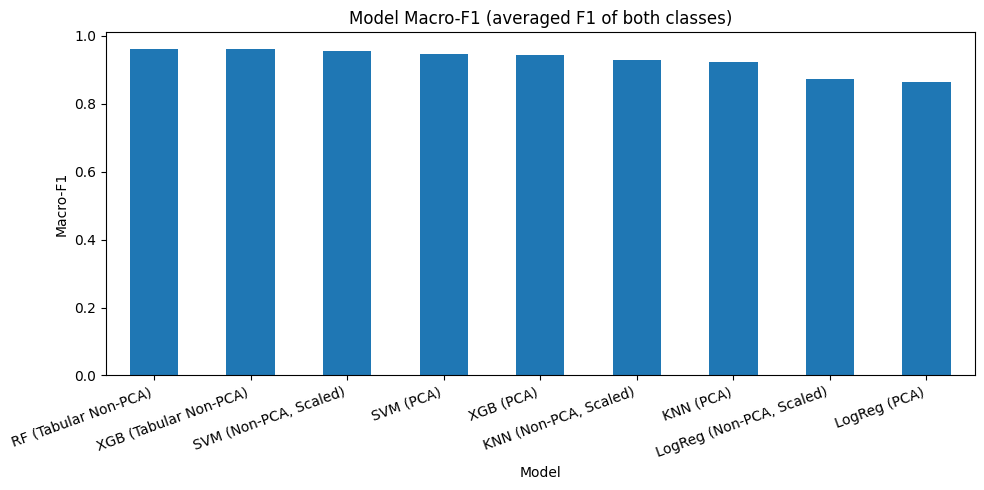

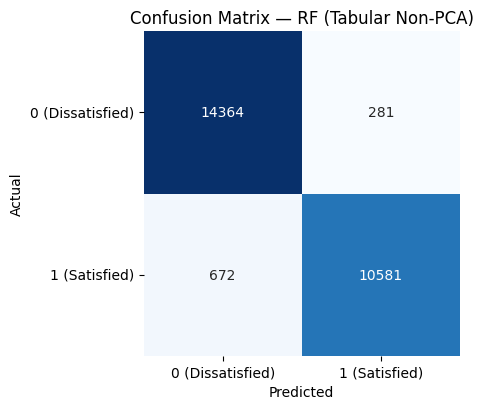

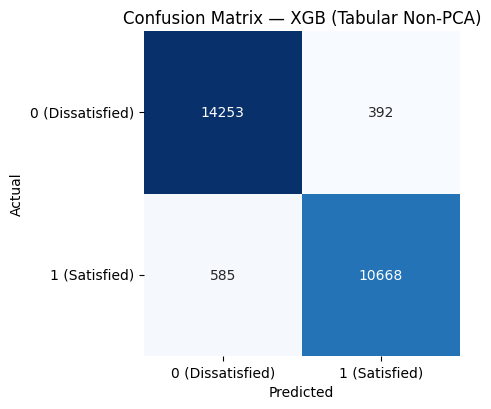

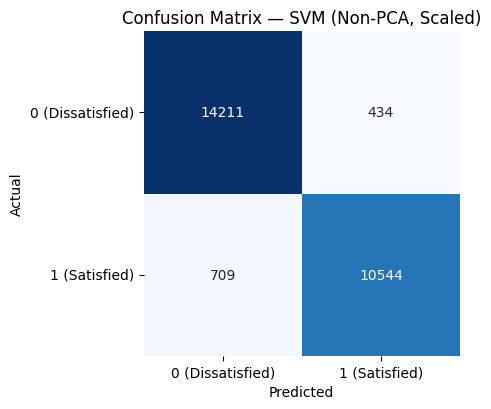

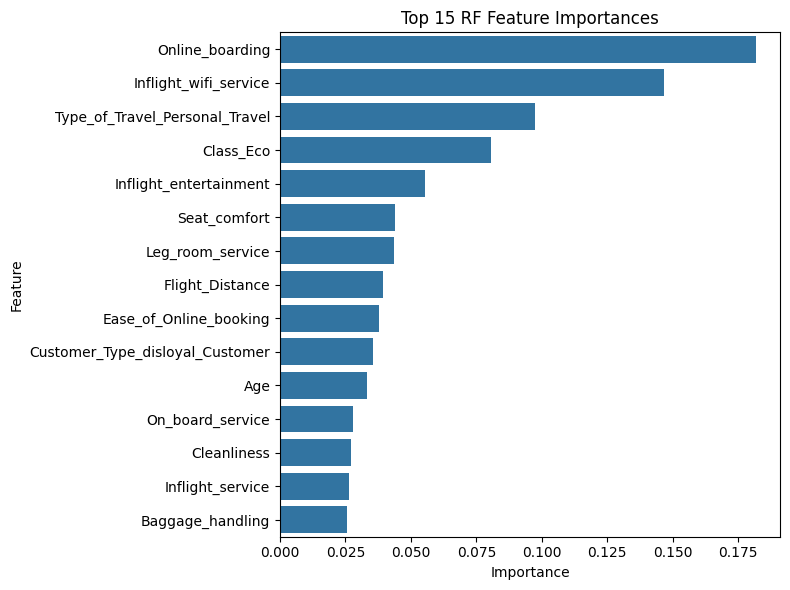


Top RF features:
                             Feature  Importance
7                   Online_boarding    0.181885
2             Inflight_wifi_service    0.146816
19   Type_of_Travel_Personal_Travel    0.097501
20                        Class_Eco    0.080513
9            Inflight_entertainment    0.055505
8                      Seat_comfort    0.044071
11                 Leg_room_service    0.043562
1                   Flight_Distance    0.039251
4            Ease_of_Online_booking    0.037761
18  Customer_Type_disloyal_Customer    0.035523
0                               Age    0.033188
10                 On_board_service    0.027981
15                      Cleanliness    0.027248
14                 Inflight_service    0.026476
12                 Baggage_handling    0.025418


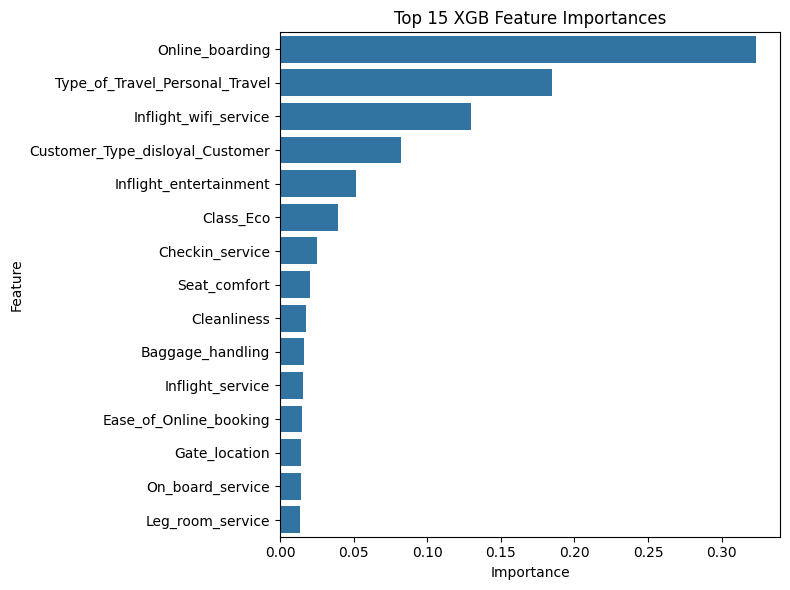


Top XGB features:
                             Feature  Importance
7                   Online_boarding    0.323520
19   Type_of_Travel_Personal_Travel    0.184582
2             Inflight_wifi_service    0.129594
18  Customer_Type_disloyal_Customer    0.082207
9            Inflight_entertainment    0.051306
20                        Class_Eco    0.039457
13                  Checkin_service    0.024886
8                      Seat_comfort    0.020078
15                      Cleanliness    0.017767
12                 Baggage_handling    0.016539
14                 Inflight_service    0.015911
4            Ease_of_Online_booking    0.014695
5                     Gate_location    0.014170
10                 On_board_service    0.014134
11                 Leg_room_service    0.013812


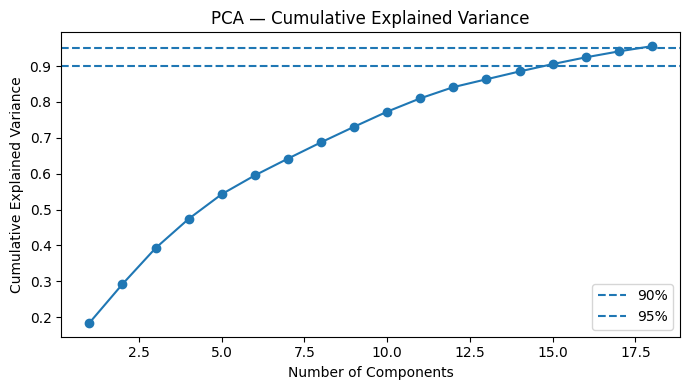

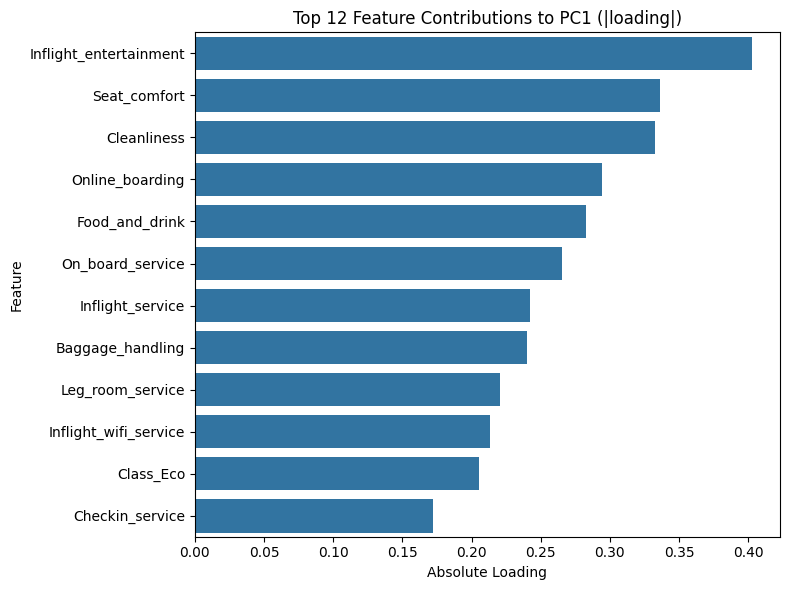

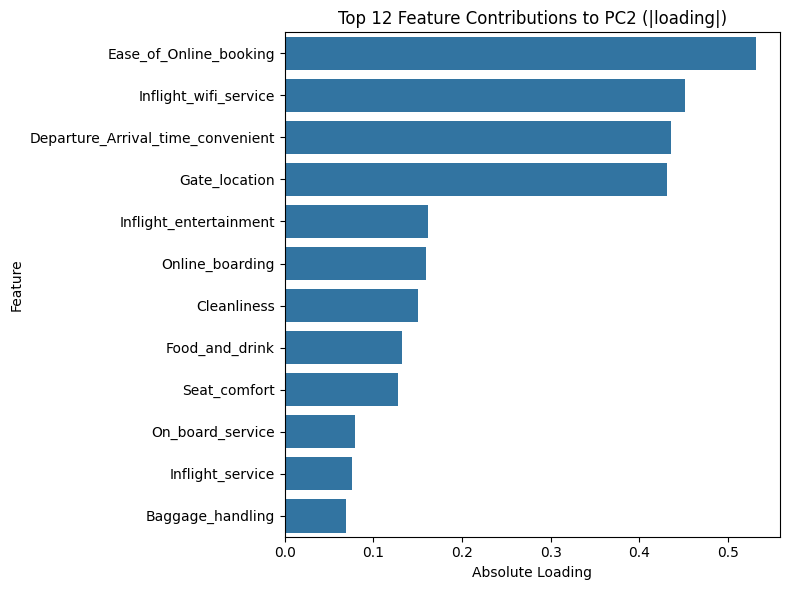

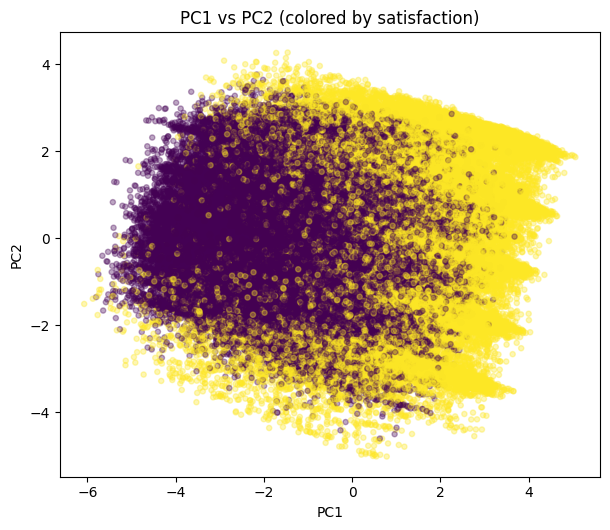

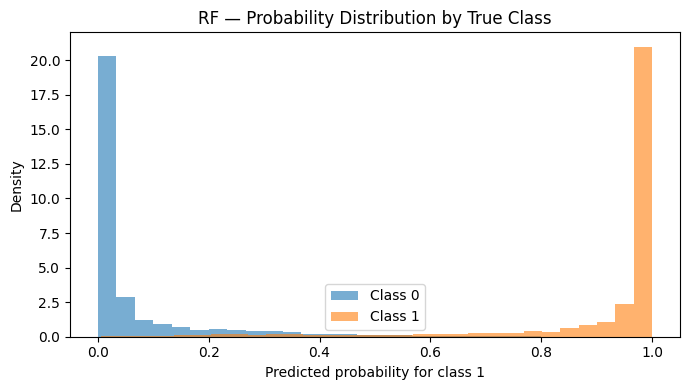

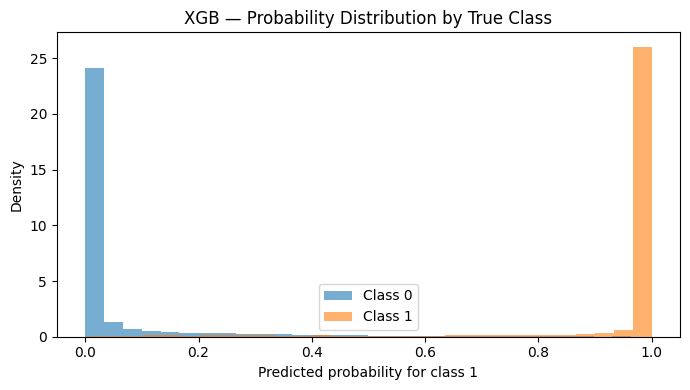

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 11 08:05:47 2025

@author: heidi
"""

# ============================ STABILITY (Windows/Spyder) ============================
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ============================ Imports ============================
import re
import numpy as np
import pandas as pd
from google.colab import drive

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# XGBoost (optional)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("ℹ️ Skipping XGBoost (import failed):", e)

# ============================ Config ============================
N_JOBS_PAR = 2          # keep modest to avoid freezes
PCA_VARIANCE = 0.95     # keep ~95% variance for PCA

# ============================ 1) Load & basic clean ============================
#https://tafewa-my.sharepoint.com/:x:/g/personal/20134571_tafe_wa_edu_au/EUqNvfPuJeNOtuYHbtuR3-kBCuTG4uzDvUE8wWMTvdUjjw?e=NFwe2t

import pandas as pd
from google.colab import files
url = "https://raw.githubusercontent.com/20134571/AISKILLSET/main/airline_satisfaction_cleaned_ungrouped.csv"
df = pd.read_csv(url)
print (df)

print(df.head())

#df = pd.read_csv("airline_satisfaction_cleaned_ungrouped.csv")
df = df.dropna().reset_index(drop=True)

target_col = "satisfaction"
drop_cols = ["Unnamed: 0", "id", "Arrival Delay in Minutes"]  # adjust if you want to keep arrival delay

# ============================ 2) Build X, y ============================
X = df.drop(columns=[c for c in drop_cols if c in df.columns] + [target_col]).copy()
y = df[target_col].copy()

# ---- Ensure numeric features: one-hot encode only if needed ----
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if cat_cols:
    preview = cat_cols[:10]
    print(f"One-hot encoding {len(cat_cols)} categorical columns: {preview}{' ...' if len(cat_cols)>10 else ''}")
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
else:
    print("No categorical columns detected — skipping one-hot encoding.")

# ---- Sanitize column names for XGBoost safety ----
def _sanitize(s: str) -> str:
    s = str(s)
    s = re.sub(r"[^\w]+", "_", s)    # replace non-alphanumerics with _
    s = re.sub(r"_+", "_", s).strip("_")
    return s

X.columns = [_sanitize(c) for c in X.columns]
print(f"Features after encoding: {X.shape[1]}")

# ============================ 3) Unified split (shared by all models) ============================
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(sss.split(X, y))

# Tabular view (for RF/XGB; also the base for scaling/PCA)
X_train_tab = X.iloc[train_idx].copy()
X_test_tab  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test  = y.iloc[test_idx].copy()

# Non-PCA (scaled) view for distance/linear models
scaler = StandardScaler().fit(X_train_tab)
X_train_scaled = scaler.transform(X_train_tab)
X_test_scaled  = scaler.transform(X_test_tab)

# PCA view (fit on TRAIN ONLY to avoid leakage)
pca = PCA(n_components=PCA_VARIANCE, random_state=42).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print(f"PCA reduced features:    {X_train_pca.shape[1]}")

# ============================ 4) Train models (both PCA & non-PCA) ============================

def summarize(y_true, y_pred, name):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Prec_0": rep["0"]["precision"], "Rec_0": rep["0"]["recall"], "F1_0": rep["0"]["f1-score"],
        "Prec_1": rep["1"]["precision"], "Rec_1": rep["1"]["recall"], "F1_1": rep["1"]["f1-score"],
        "MacroF1": (rep["0"]["f1-score"] + rep["1"]["f1-score"]) / 2,
        "WeightedF1": rep["weighted avg"]["f1-score"],
    }

rows = []

# ---------- Non-PCA (scaled) ----------
knn_np = KNeighborsClassifier(n_neighbors=9).fit(X_train_scaled, y_train)
rows.append(summarize(y_test, knn_np.predict(X_test_scaled), "KNN (Non-PCA, Scaled)"))

logreg_np = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_scaled, y_train)
rows.append(summarize(y_test, logreg_np.predict(X_test_scaled), "LogReg (Non-PCA, Scaled)"))

svm_np = SVC(kernel='rbf', random_state=42).fit(X_train_scaled, y_train)
rows.append(summarize(y_test, svm_np.predict(X_test_scaled), "SVM (Non-PCA, Scaled)"))

# ---------- PCA ----------
knn_pca = KNeighborsClassifier(n_neighbors=9).fit(X_train_pca, y_train)
rows.append(summarize(y_test, knn_pca.predict(X_test_pca), "KNN (PCA)"))

logreg_pca = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_pca, y_train)
rows.append(summarize(y_test, logreg_pca.predict(X_test_pca), "LogReg (PCA)"))

svm_pca = SVC(kernel='rbf', random_state=42).fit(X_train_pca, y_train)
rows.append(summarize(y_test, svm_pca.predict(X_test_pca), "SVM (PCA)"))

# ---------- Random Forest (NON-PCA ONLY) ----------
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=N_JOBS_PAR)
rf.fit(X_train_tab, y_train)
rows.append(summarize(y_test, rf.predict(X_test_tab), "RF (Tabular Non-PCA)"))

# ---------- XGBoost (both Tabular and PCA) ----------
if HAS_XGB:
    # class balance for mild imbalance (~57/43)
    neg, pos = int((y_train == 0).sum()), int((y_train == 1).sum())
    spw = neg / max(pos, 1)

    # Tabular (recommended)
    xgb_tab = XGBClassifier(
        objective="binary:logistic", eval_metric="logloss", tree_method="hist",
        n_estimators=500, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=spw, random_state=42, n_jobs=N_JOBS_PAR
    )
    xgb_tab.fit(X_train_tab, y_train)
    rows.append(summarize(y_test, xgb_tab.predict(X_test_tab), "XGB (Tabular Non-PCA)"))

    # PCA (for comparison)
    xgb_pca = XGBClassifier(
        objective="binary:logistic", eval_metric="logloss", tree_method="hist",
        n_estimators=500, max_depth=6, learning_rate=0.1,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        scale_pos_weight=spw, random_state=42, n_jobs=N_JOBS_PAR
    )
    xgb_pca.fit(X_train_pca, y_train)
    rows.append(summarize(y_test, xgb_pca.predict(X_test_pca), "XGB (PCA)"))

# ============================ 5) Results table ============================
df_results = pd.DataFrame(rows).set_index("Model").round(3)
print("\n=== Results (Both PCA & Non-PCA; RF Non-PCA only) ===")
print(df_results.sort_values(["Accuracy", "MacroF1"], ascending=False))

# (Optional) save to CSV
# df_results.to_csv("results_pca_vs_nonpca_all.csv")


# ========================= VISUALIZATIONS =========================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---------- 1) Leaderboard: Accuracy & MacroF1 ----------
df_plot = df_results[["Accuracy", "MacroF1"]].copy().sort_values("Accuracy", ascending=False)
plt.figure(figsize=(10,5))
df_plot["Accuracy"].plot(kind="bar")
plt.title("Model Accuracy (higher is better)")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
df_plot["MacroF1"].plot(kind="bar")
plt.title("Model Macro-F1 (averaged F1 of both classes)")
plt.ylabel("Macro-F1")
plt.xticks(rotation=20, ha="right")
plt.tight_layout(); plt.show()

# ---------- 2) Confusion matrices for top performers ----------
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.2))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.xticks([0.5,1.5], ["0 (Dissatisfied)","1 (Satisfied)"])
    plt.yticks([0.5,1.5], ["0 (Dissatisfied)","1 (Satisfied)"], rotation=0)
    plt.tight_layout(); plt.show()

# Recompute preds (models are already fit)
plot_cm(y_test, rf.predict(X_test_tab),      "Confusion Matrix — RF (Tabular Non-PCA)")
try:
    plot_cm(y_test, xgb_tab.predict(X_test_tab), "Confusion Matrix — XGB (Tabular Non-PCA)")
except NameError:
    pass
plot_cm(y_test, svm_np.predict(X_test_scaled), "Confusion Matrix — SVM (Non-PCA, Scaled)")

# ---------- 3) Feature importances (RF & XGB) ----------
# RF
rf_imp = (pd.DataFrame({"Feature": X_train_tab.columns, "Importance": rf.feature_importances_})
          .sort_values("Importance", ascending=False).head(15))
plt.figure(figsize=(8,6))
sns.barplot(data=rf_imp, x="Importance", y="Feature")
plt.title("Top 15 RF Feature Importances")
plt.tight_layout(); plt.show()
print("\nTop RF features:\n", rf_imp)

# XGB (if available)
try:
    xgb_imp = (pd.DataFrame({"Feature": X_train_tab.columns, "Importance": xgb_tab.feature_importances_})
               .sort_values("Importance", ascending=False).head(15))
    plt.figure(figsize=(8,6))
    sns.barplot(data=xgb_imp, x="Importance", y="Feature")
    plt.title("Top 15 XGB Feature Importances")
    plt.tight_layout(); plt.show()
    print("\nTop XGB features:\n", xgb_imp)
except NameError:
    pass

# ---------- 4) PCA visuals (explained variance, loadings, scatter) ----------
# 4a) Cumulative explained variance
cum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(7,4))
plt.plot(range(1, len(cum)+1), cum, marker='o')
plt.axhline(0.90, linestyle='--', label='90%')
plt.axhline(0.95, linestyle='--', label='95%')
plt.xlabel("Number of Components"); plt.ylabel("Cumulative Explained Variance")
plt.title("PCA — Cumulative Explained Variance"); plt.legend(); plt.tight_layout(); plt.show()

# 4b) Loadings: which features drive PC1/PC2
loadings = pd.DataFrame(
    pca.components_.T,
    index=X_train_tab.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
for pc in ["PC1", "PC2"]:
    if pc in loadings.columns:
        top = loadings[pc].abs().sort_values(ascending=False).head(12)
        plt.figure(figsize=(8,6))
        sns.barplot(x=top.values, y=top.index, orient="h")
        plt.title(f"Top {len(top)} Feature Contributions to {pc} (|loading|)")
        plt.xlabel("Absolute Loading"); plt.ylabel("Feature")
        plt.tight_layout(); plt.show()

# 4c) PC1 vs PC2 scatter (whole dataset, colored by satisfaction)
X_scaled_all = scaler.transform(X)
PC_all = pca.transform(X_scaled_all)
plt.figure(figsize=(6.2,5.4))
plt.scatter(PC_all[:,0], PC_all[:,1], c=y, alpha=0.35, s=14)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PC1 vs PC2 (colored by satisfaction)")
plt.tight_layout(); plt.show()

# ---------- 5) (Optional) Probability histograms for RF/XGB ----------
#   Shows separation between classes; useful for threshold talk (no ROC needed)
def prob_hist(model, X_te, y_te, title):
    if not hasattr(model, "predict_proba"):
        return
    p = model.predict_proba(X_te)[:,1]
    plt.figure(figsize=(7,4))
    plt.hist(p[y_te==0], bins=30, alpha=0.6, label="Class 0", density=True)
    plt.hist(p[y_te==1], bins=30, alpha=0.6, label="Class 1", density=True)
    plt.xlabel("Predicted probability for class 1"); plt.ylabel("Density")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

prob_hist(rf, X_test_tab, y_test, "RF — Probability Distribution by True Class")
try:
    prob_hist(xgb_tab, X_test_tab, y_test, "XGB — Probability Distribution by True Class")
except NameError:
    pass
